## TEVAR segmentation tutorial with SIRE repo

In [1]:
import sys
sys.path.append("../")

### Defining the global controller

In [2]:
import SimpleITK as sitk

from src.sire.inference.totalsegmentator_processor import Roi, TotalSegmentatorProcessor
from src.sire.inference.utils.step_schedulers import ConstantStepScheduler
from src.sire.inference.utils.stopping_criterions import RoiStoppingCriterion, VesselDiameterStoppingCriterion
from src.sire.inference.utils.vessel_config import VesselConfig


class TevarController(TotalSegmentatorProcessor):

    def __call__(self, image_path: str, output_dir: str, seed_path: str = None, device: str = "cpu"):

        # Run the prior total segmentator
        mask, affine = self.run(image_path, output_dir, device)
        _ = sitk.GetArrayFromImage(sitk.ReadImage(image_path))

        # Setup rois
        segments = {
            # Outside of the heart, above T12 vertebrae
            "thoracic_aorta": {
                "diameter": {"min": None, "max": None},
                "roi": Roi.intersection(mask, [Roi([32], "above", "max"), Roi([51], "outside")]),
                "step": 1,
            },
        }

        # Load seed points from .mrk.json file
        if seed_path is not None:
            seeds = self.load_manual_slicer_landmarks(seed_path)
            seed_segments = {}

            for name, point in seeds.items():
                if name in segments.keys():
                    seed_segments[name] = segments[name]
                    seed_segments[name]["seed"] = point

            segments = seed_segments
            
        # Automatically find the seed point for thoracic aorta
        else:
            segments["thoracic_aorta"]["seed"] = self._get_seed(mask, affine, segments["thoracic_aorta"]["roi"], 52, p=0.2)

        # Return list of vessel configs
        return [
            VesselConfig(
                name=name,
                seed_point=params["seed"],
                segment_every_n_steps=5,
                step_scheduler=ConstantStepScheduler(params["step"]),
                stopping_criterions=[
                    RoiStoppingCriterion(params["roi"]),
                    VesselDiameterStoppingCriterion(
                        max_diameter=params["diameter"]["max"], min_diameter=params["diameter"]["min"]
                    ),
                ],
            )
            for name, params in segments.items()
        ]


### Running SIRE segmentation pipeline

In [5]:
import os, glob
from tqdm.auto import tqdm

# Import SIRE pipeline
from src.sire.inference.segmentator_tracker import SegmentatorTrackerPipeline

# Import inference models
from src.sire.inference.inference_models import SegmentationInferenceModel, TrackerInferenceModel

# Import pytorch model classes
from src.sire.models.sire_seg import SIRESegmentation
from src.sire.models.sire_tracker import SIRETracker

def inference(
    root_dir: str,
    output_dir: str,
    device: str,
    seeds_dir: str = None
):
    path_dict = {
        path.split("/")[-1].split(".")[0]: path
        for path in glob.glob(os.path.join(root_dir, "**/*.mhd"), recursive=True)
    }

    # Load tracking model
    tracker_model = TrackerInferenceModel(
        model=SIRETracker.load_from_checkpoint("../src/sire/models/checkpoints/tracking_model.ckpt"),
        scales=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
        npoints=32,
        subdivisions=3,
        device=device,
    )

    # Load segmentation model
    segmentation_models = [
        SegmentationInferenceModel(
            model=SIRESegmentation.load_from_checkpoint("../src/sire/models/checkpoints/segmentation_model.ckpt"),
            names=["lumen"],
            scales=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
            npoints=32,
            subdivisions=2,
            device=device,
        ),
    ]

    # Prepare pipeline
    controller = TevarController()
    tracker_pipeline = SegmentatorTrackerPipeline(tracker_model, segmentation_models)

    # Running for each sample
    for sample, image_path in tqdm(path_dict.items(), desc="Samples"):
        os.makedirs(os.path.join(output_dir, sample), exist_ok=True)
        sample_dir = os.path.join(output_dir, sample)

        if seeds_dir is not None:
            seed_path = os.path.join(seeds_dir, f"{sample}_seeds.mrk.json")
        else:
            seed_path = None

        vessel_configs = controller(
            image_path,
            sample_dir,
            seed_path=seed_path,
            device=device if device != "cuda" else "gpu",
        )
        tracker_pipeline.run(
            image_path,
            output_dir=sample_dir,
            vessel_configs=vessel_configs,
            already_tracked_distance=1,
        )

### Run the segmentation pipeline

In [6]:
root_dir = "/Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/mhd"
output_dir = "/Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-segmentation"
seeds_dir = "/Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/seeds"
device = "cpu"

inference(root_dir, output_dir, device, seeds_dir)

Samples:   0%|          | 0/1 [00:00<?, ?it/s]

RICH_INFO (2024-11-14 16:53:13,267): Running TotalSegmentator preprocessing
/Users/patrykrygiel/anaconda3/envs/sire/lib/python3.11/site-packages/nnunetv2/inference/export_prediction.py:67: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(old_threads)
RICH_INFO (2024-11-14 16:54:58,274): Pipeline started


  0%|          | 0/1 [00:00<?, ?it/s]

RICH_INFO (2024-11-14 16:54:58,859): Preparing data
RICH_INFO (2024-11-14 16:54:59,401): Seed_point: tensor([  71.9489,   40.6332, -194.7256], dtype=torch.float64)
RICH_INFO (2024-11-14 16:54:59,797): Direction: tensor([ 0.0000, -0.2733, -0.9619], dtype=torch.float64)
RICH_INFO (2024-11-14 16:55:33,370): Stopped after 104 iterations: ['RoiStoppingCriterion()']
RICH_INFO (2024-11-14 16:55:33,371): Direction: tensor([0.0000, 0.2733, 0.9619], dtype=torch.float64)
RICH_INFO (2024-11-14 16:57:02,759): Stopped after 274 iterations: ['RoiStoppingCriterion()']
RICH_INFO (2024-11-14 16:57:02,761): Finished
RICH_INFO (2024-11-14 16:57:06,114): Pipeline finished


### Run contour meshing

In [8]:
import torch
import numpy as np
import pyvista as pv

from pqdm.processes import pqdm

from src.sire.inr import INR, INRSkeletonPointData
from src.sire.inr.losses import ManifoldLoss, NeuralPullLoss, SkeletonLoss
from src.sire.inr.models import Siren

def euler_characteristic(poly: pv.PolyData):
    return poly.n_points - poly.extract_all_edges().n_lines + poly.n_faces_strict

def reconstruct(name: str, out_dir: str, contour: np.array, centerline: np.array, omega: int):
    losses = [(NeuralPullLoss(), 0.15), (ManifoldLoss(), 0.05), (SkeletonLoss(), 0.1)]

    os.makedirs(os.path.join(out_dir, "models"), exist_ok=True)
    os.makedirs(os.path.join(out_dir, "meshes"), exist_ok=True)

    if len(contour.reshape(-1, 3)) < 500:
        print(f"{os.path.join(out_dir, name)}: Invalid contour")
        return 1

    inr_point_data = INRSkeletonPointData(
        torch.tensor(centerline), torch.tensor(contour.reshape(-1, 3)), norm_scale=1.6
    )
    inr_module = INR(Siren([3, 64, 64, 64, 64, 64, 64, 1], omega=omega), losses=losses, device="cpu")
    inr_module.fit(inr_point_data, n_points=1000, n_iters=5_000, verbose=False, plots=False)
    inr_module.export_to_onnx((1000, 3), os.path.join(out_dir, "models", f"{name}_{omega}.onnx"))

    poly, sdf = inr_point_data.reconstruct_pyvista(
        os.path.join(out_dir, "models", f"{name}_{omega}.onnx"), resolution=256, verbose=False
    )

    if euler_characteristic(poly) == 2:
        poly.save(sample := os.path.join(out_dir, "meshes", f"{name}_{omega}.vtp"))
        print(f"Correct topology - saving sample: {sample}")

    return name, omega, euler_characteristic(poly)

In [11]:
def get_sample(input_dir: str, sample: str, segment: str):
    contour = pv.read(os.path.join(input_dir, sample, "contour", "lumen", f"contour_{segment}.vtp"))
    contour = contour.points.reshape(-1, 128, 3)

    return contour, contour.mean(axis=1)

In [13]:
n_jobs = 1
omegas = [6, 8, 10, 12, 14, 16]
segments = ["thoracic_aorta"]

input_dir = "/Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-segmentation"
output_dir = "/Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction"

args = [
    (
        segment,
        os.path.join(output_dir, sample),
        *get_sample(input_dir, sample, segment),
        omega,
    )
    for omega in omegas 
    for segment in segments
    for sample in os.listdir(input_dir)
]

pqdm(args, reconstruct, argument_type="args", n_jobs=n_jobs)

  0%|          | 0/6 [00:00<?, ?it/s]

Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_6.vtp
Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_8.vtp
Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_10.vtp
Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_12.vtp
Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_14.vtp
Correct topology - saving sample: /Users/patrykrygiel/Documents/UTWENTE/Datasets/Other/Milou-test/raw-reconstruction/tevar_001/meshes/thoracic_aorta_16.vtp


[('thoracic_aorta', 6, 2),
 ('thoracic_aorta', 8, 2),
 ('thoracic_aorta', 10, 2),
 ('thoracic_aorta', 12, 2),
 ('thoracic_aorta', 14, 2),
 ('thoracic_aorta', 16, 2)]

#### Results for different smoothing factors (omega)
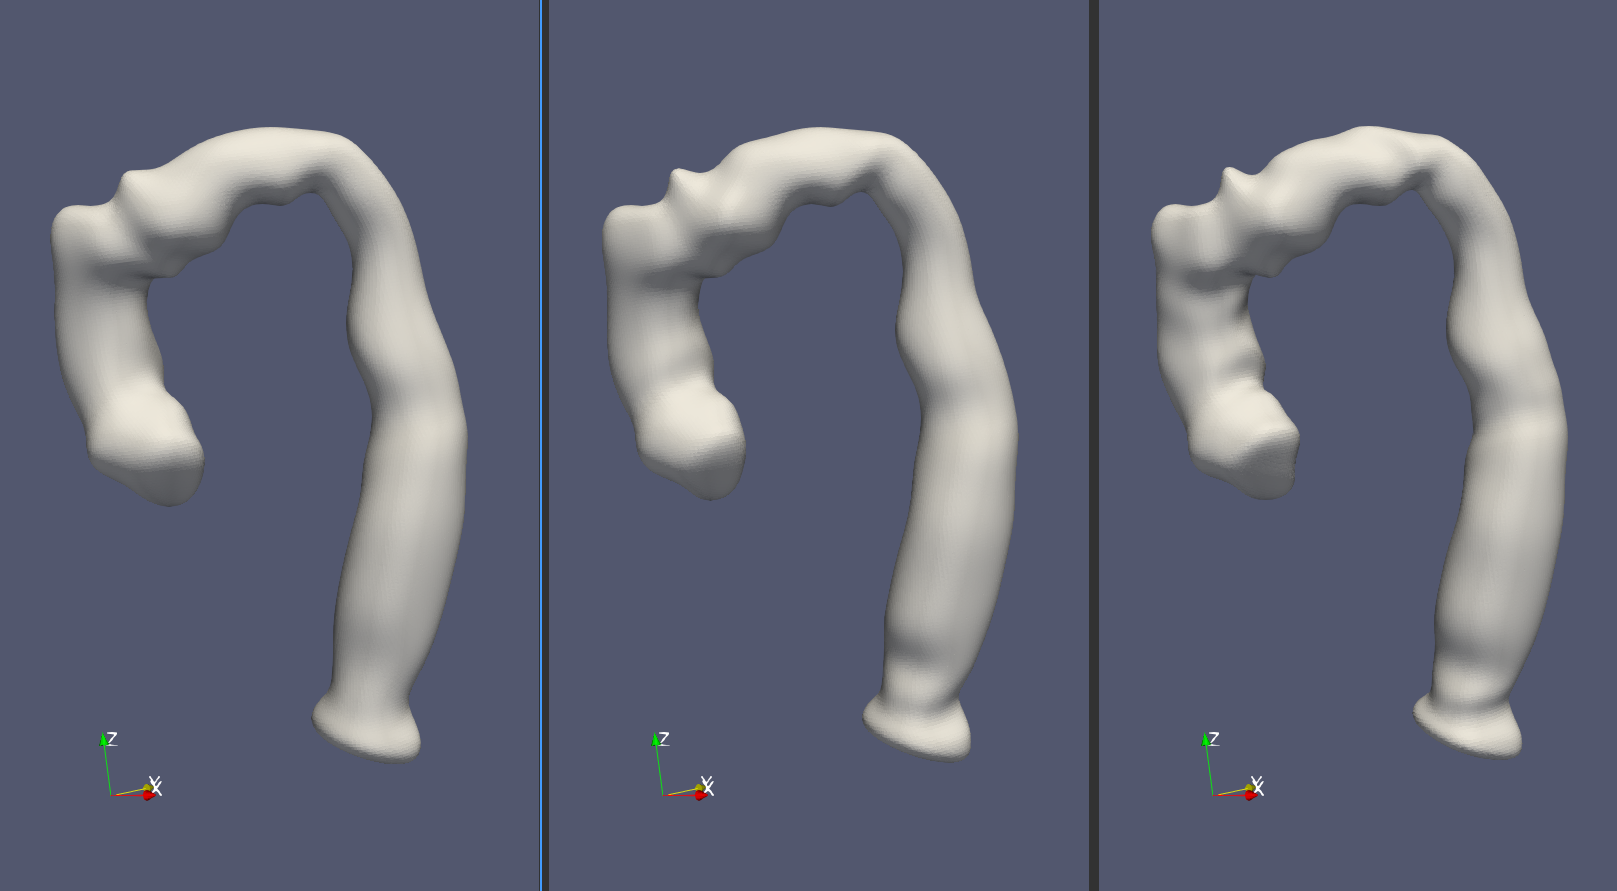